*CO2 emissions by country - Hypothesis Testing and Model Building*


# <font color = "Red"> Case Study </font>

In this case we are going to analyze part of the World Bank database concerning the **Environment** set of the **World Development Indicators**. In particular we are given a set of countries and several variables (see description in the tables below and visit the World Bank webpage to see a more detailed description) related to

 * **Emission**: gas emissions related to different types of gasees as well as greenhouse emissions
 * **Energy Production**: electricity consumption and production from different sources
 * **Descriptive**: description of each observation. Note that the `year` variable takes three different values: 2000, 2010 and 2012. This last value is the las available, at this moment, in the dataset.

In [0]:
# @hidden_cell
from IPython.display import HTML
HTML('<table style="margin-left:auto;margin-right:auto;"><caption style = "text-align: center;">Table 1.- Emission Variables</caption><tr><th>Variable</th><th style="text-align: center;">Description</th><th style="text-align: center;">Licence URL</th></tr><tr><td>co2em</td><td>CO2 emissions (kt)</td><td>1</td></tr><tr><td>co2emgas</td><td>CO2 emissions from gaseous fuel consumption (kt)</td><td>1</td></tr><tr><td>co2emliq</td><td>CO2 emissions from liquid fuel consumption (kt)</td><td>1</td></tr><tr><td>co2emsol</td><td>CO2 emissions from solid fuel consumption (kt)</td><td>1</td></tr><tr><td>ghg</td><td>GHG net emissions/removals by LUCF (Mt of CO2 equivalent)</td><td>1</td></tr><tr><td>hfc</td><td>HFC gas emissions (thousand metric tons of CO2 equivalent)</td><td>1</td></tr><tr><td>methane</td><td>Methane emissions (kt of CO2 equivalent)</td><td>1</td></tr><tr><td>nitrousox</td><td>Nitrous oxide emissions (thousand metric tons of CO2 equivalent)</td><td>1</td></tr><tr><td>pfc</td><td>PFC gas emissions (thousand metric tons of CO2 equivalent)</td><td>1</td></tr><tr><td>sf6</td><td>SF6 gas emissions (thousand metric tons of CO2 equivalent)</td><td>1</td></tr><tr><td>ghother</td><td>Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)</td><td>1</td></tr><tr><td>ghtotal</td><td>Total greenhouse gas emissions (kt of CO2 equivalent)</td><td>1</td></tr><tr><td>ghchange</td><td>Total greenhouse gas emissions (% change from 1990)</td><td>1</td></tr></table>')

Variable,Description,Licence URL
co2em,CO2 emissions (kt),1
co2emgas,CO2 emissions from gaseous fuel consumption (kt),1
co2emliq,CO2 emissions from liquid fuel consumption (kt),1
co2emsol,CO2 emissions from solid fuel consumption (kt),1
ghg,GHG net emissions/removals by LUCF (Mt of CO2 equivalent),1
hfc,HFC gas emissions (thousand metric tons of CO2 equivalent),1
methane,Methane emissions (kt of CO2 equivalent),1
nitrousox,Nitrous oxide emissions (thousand metric tons of CO2 equivalent),1
pfc,PFC gas emissions (thousand metric tons of CO2 equivalent),1
sf6,SF6 gas emissions (thousand metric tons of CO2 equivalent),1


In [0]:
# @hidden_cell
HTML('<table style="margin-left:auto;margin-right:auto;"><caption style = "text-align: center;">Table 2.- Energy Production and Use</caption><tr><th>Variable</th><th style="text-align: center;">Description</th><th style="text-align: center;">Licence URL</th></tr><tr><td>epcoal</td><td>Electricity production from coal sources (% of total)</td><td>2</td></tr><tr><td>ephydro</td><td>Electricity production from hydroelectric sources (% of total)</td><td>2</td></tr><tr><td>epgas</td><td>Electricity production from natural gas sources (% of total)</td><td>2</td></tr><tr><td>epnuclear</td><td>Electricity production from nuclear sources (% of total)</td><td>2</td></tr><tr><td>epoil</td><td>Electricity production from oil sources (% of total)</td><td>2</td></tr><tr><td>renerout</td><td>Renewable electricity output (% of total electricity output)</td><td>2</td></tr><tr><td>epowcons</td><td>Electric power consumption (kWh per capita)</td><td>2</td></tr><tr><td>renercons</td><td>Renewable energy consumption (% of total final energy consumption)</td><td>1</td></tr></table>')

Variable,Description,Licence URL
epcoal,Electricity production from coal sources (% of total),2
ephydro,Electricity production from hydroelectric sources (% of total),2
epgas,Electricity production from natural gas sources (% of total),2
epnuclear,Electricity production from nuclear sources (% of total),2
epoil,Electricity production from oil sources (% of total),2
renerout,Renewable electricity output (% of total electricity output),2
epowcons,Electric power consumption (kWh per capita),2
renercons,Renewable energy consumption (% of total final energy consumption),1


where the licence for use and distribution of the data con be found in the following URLs:

 * Licence 1 (World Bank License): https://datacatalog.worldbank.org/public-licenses#cc-by
 * Licence 2 (IEA License): http://www.iea.org/t&c/termsandconditions
 
Apart from these variables we have other descriptive variables

In [0]:
# @hidden_cell
HTML('<table style="margin-left:auto;margin-right:auto;"><caption style = "text-align: center;">Table 3.- Descriptive Context</caption><tr><th>Variable</th><th style="text-align: center;">Description</th></tr><tr><td>country</td><td>Name of the country</td></tr><tr><td>year</td><td>Years for the data: 2000, 2010 and 2012</td></tr><tr><td>continent</td><td>Continent of the country: Africa, America, Asia, Australia and Europe</td></tr></table>')

Variable,Description
country,Name of the country
year,"Years for the data: 2000, 2010 and 2012"
continent,"Continent of the country: Africa, America, Asia, Australia and Europe"


We will analyze them in order to gain a deeper understanding of the general discussion on climate change (note that we do not include explicit climate change variables as could be the `temperature`, but we will obtain insights about the general context)

In [0]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.formula.api import ols
from scipy.stats import mstats

## <font color = "MediumBlue">Functions</font>

In [0]:
# @hidden_cell
def NormalityTests(x, sig_level):
    '''
    This function computes the p-value and statistics of the Shapiro-Wilk and D'Agostino tests for normality
    It also includes the set of libraries to be loaded in the test (no cheks done)
    
    Inputs:
    
     - x: array of values of the variable to be tested
     - sig_level: significance level to be used in the decision of the test
    
    Output
    
     - p-value, statistic and decision for both tests    
    '''
    from scipy.stats import shapiro
    from scipy.stats import normaltest
    
    shap_stat, shap_p = shapiro(x)
    k2_stat, k2_p = normaltest(x)
    
    print("From the Shapiro Wilk test:\n\nStatistic: ", shap_stat, "\np-value: ", shap_p)
    if shap_p > sig_level:
        print("Fail to reject Normality: No evidence found against normality\n\n")
    else:
        print("Reject Normality: Evidence found against normality\n\n")
    
    print("From the D'Agostino test:\n\nStatistic: ", k2_stat, "\np-value: ", k2_p)
    if k2_p > sig_level:
        print("Fail to reject Normality: No evidence found against normality\n\n")
    else:
        print("Reject Normality: Evidence found against normality\n\n")
             

def HisQQplots(x):
    '''
    This function plots the histogram and qq-plot of an array in order to perform a visual analysis of normality
    
    Inputs:
    
     - x: array to plot
    
    Output:
    
     A plot consisting in two subplots (one for each of the previous ones)
    '''
    # define the different regions
    f, (ax_box, ax_hist) = plt.subplots(2, 
                                        sharex = False, 
                                        gridspec_kw={"height_ratios": (.25, .75)})
    f.set_figheight(8)
    f.set_figwidth(8)
    plt.suptitle('Normality Plots', fontsize = 20)
    # Add a graph in each part
    sns.distplot(x, hist = True, 
                 kde = False, 
                 bins = 10, 
                 hist_kws={'edgecolor':'black'},
                 ax=ax_box)
    ss.probplot(x, plot=sns.mpl.pyplot)
    plt.tight_layout(rect=(0,0,1,0.94))
    plt.show()


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_excel("/content/drive/My Drive/IE Bootcamp - Math & Stats /Exams/EmissionsAndEnergy.xlsx", na_values="na", sheet_name="data")

# <font color = "Red"> Questions</font>

## 1.- <font color = "MediumBlue"> Greenhouse Emissions </font>

### 1.1.- <font color = "Blue"> Normality </font>

Let's first focus on the `ghtotal` and `ghchange` variables

In [0]:
NormalityTests(df[df['year'] == 2000]['ghtotal'].dropna(), 0.1)

From the Shapiro Wilk test:

Statistic:  0.30612117052078247 
p-value:  4.504911683843992e-24
Reject Normality: Evidence found against normality


From the D'Agostino test:

Statistic:  238.64993336626225 
p-value:  1.5060015409121948e-52
Reject Normality: Evidence found against normality




In [0]:
NormalityTests(df[df['year'] == 2010]['ghtotal'].dropna(), 0.1)

From the Shapiro Wilk test:

Statistic:  0.25051480531692505 
p-value:  7.501736380109695e-25
Reject Normality: Evidence found against normality


From the D'Agostino test:

Statistic:  261.44537325839553 
p-value:  1.689890394426487e-57
Reject Normality: Evidence found against normality




In [0]:
NormalityTests(df[df['year'] == 2012]['ghtotal'].dropna(), 0.1)

From the Shapiro Wilk test:

Statistic:  0.24692267179489136 
p-value:  6.705670216595621e-25
Reject Normality: Evidence found against normality


From the D'Agostino test:

Statistic:  269.528172131142 
p-value:  2.9696212548928447e-59
Reject Normality: Evidence found against normality




In [0]:
NormalityTests(df[df['year'] == 2000]['ghchange'].dropna(), 0.1)

From the Shapiro Wilk test:

Statistic:  0.5164633393287659 
p-value:  1.7882912982424805e-20
Reject Normality: Evidence found against normality


From the D'Agostino test:

Statistic:  221.73282213951614 
p-value:  7.101162385750926e-49
Reject Normality: Evidence found against normality




In [0]:
NormalityTests(df[df['year'] == 2010]['ghchange'].dropna(), 0.1)

From the Shapiro Wilk test:

Statistic:  0.4414229989051819 
p-value:  8.048411824333232e-22
Reject Normality: Evidence found against normality


From the D'Agostino test:

Statistic:  251.05341220319866 
p-value:  3.0510140570226005e-55
Reject Normality: Evidence found against normality




In [0]:
NormalityTests(df[df['year'] == 2012]['ghchange'].dropna(), 0.1)

From the Shapiro Wilk test:

Statistic:  0.45283663272857666 
p-value:  1.4703501924461069e-21
Reject Normality: Evidence found against normality


From the D'Agostino test:

Statistic:  248.6437136147266 
p-value:  1.01789647078294e-54
Reject Normality: Evidence found against normality




/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


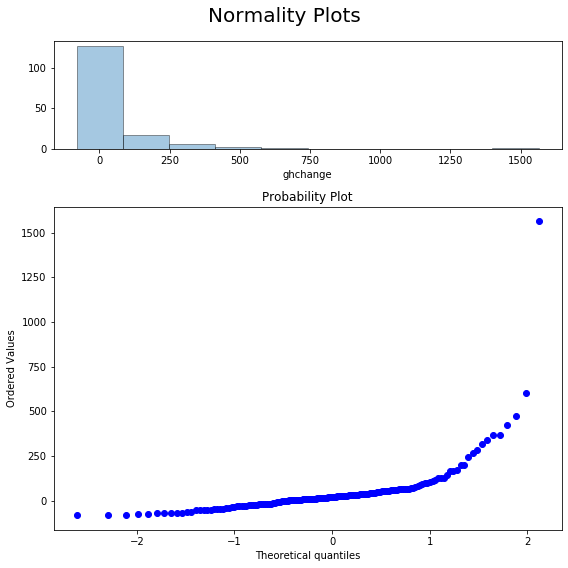

In [0]:
HisQQplots(df[df['year'] == 2000]['ghchange'])

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


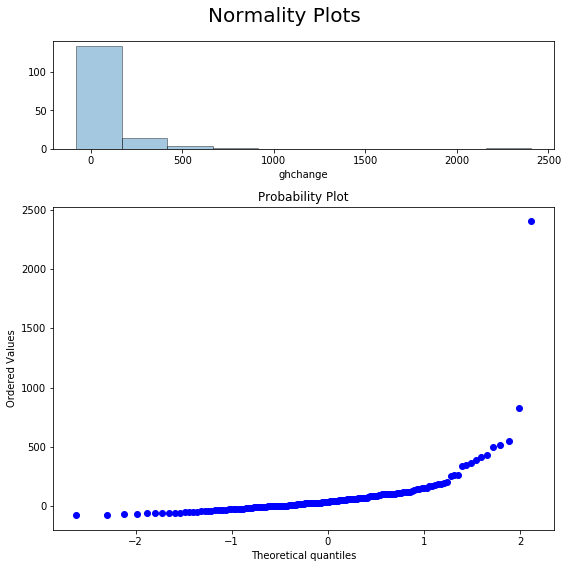

In [0]:
HisQQplots(df[df['year'] == 2010]['ghchange'])

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


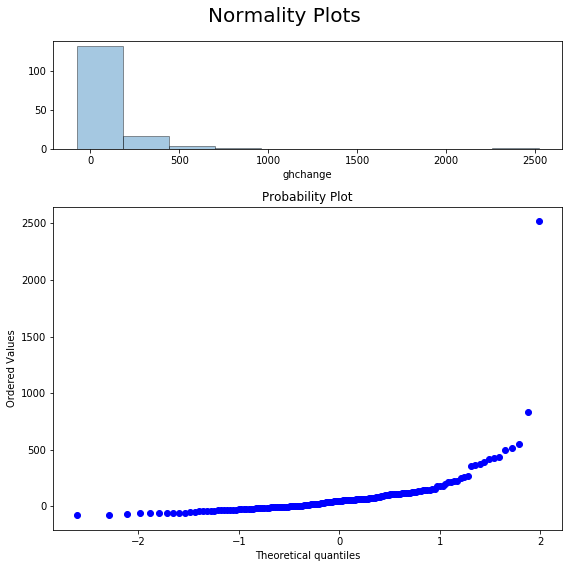

In [0]:
HisQQplots(df[df['year'] == 2012]['ghchange'])

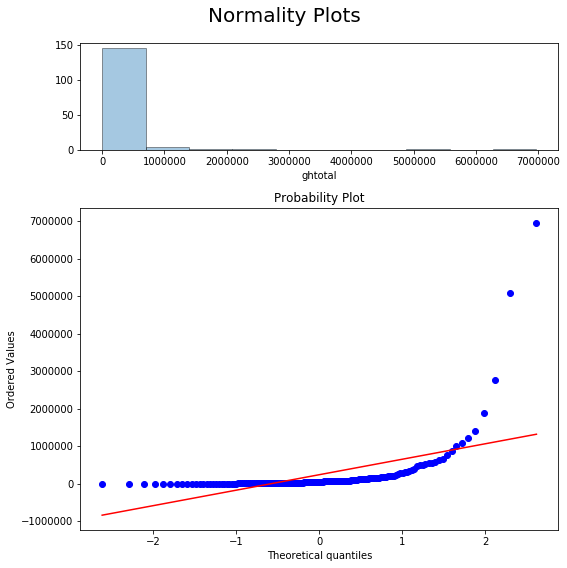

In [0]:
HisQQplots(df[df['year'] == 2000]['ghtotal'])

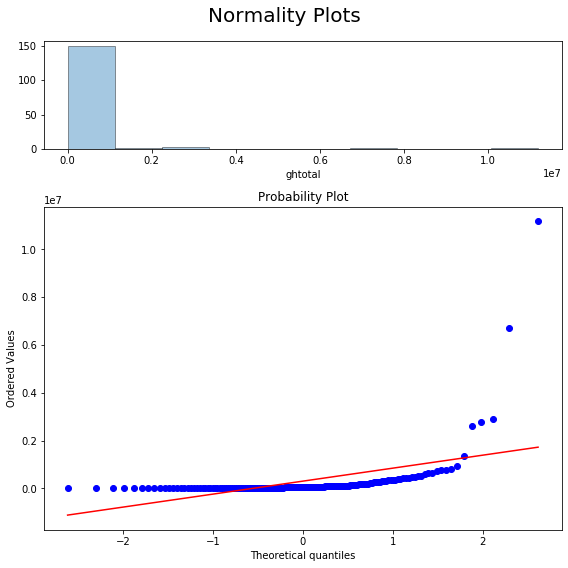

In [0]:
HisQQplots(df[df['year'] == 2010]['ghtotal'])

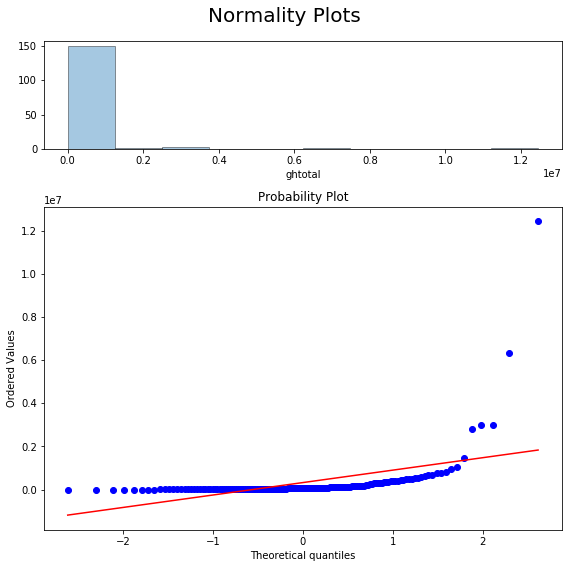

In [0]:
HisQQplots(df[df['year'] == 2012]['ghtotal'])

As we can see none of the year of variables among ghtotal and ghchange are normally distributed or passed Normality Tests. For further work with those variables, we would need to perform either log or box-cox transformation, as dropping NAs without exploring can cost us loosing some important data. 
I decided to do transformation later in actual model building, to be able to differentiate metrics of models depending on whether data was transformed or not. Also, apply better transformation for each case instead of generalizing it from the top.

### 1.2.- <font color = "Blue"> Kyoto protocol </font>

**Kyoto protocol**, signed by 55 countries, contained two important pointswith respect to the greenhouse gas emissions:

 * Stabilize them by year 2000 with respect to those of 1990
 * Reduce them a 5.2%
 
In order to test if these two points were done we will do the following steps 

 * Look for the 55 countries that signed the protocol
 * Match those countries with the ones we have in dataset


#### 1.1.2  Stabilization

In [0]:
countries = pd.read_excel("/content/drive/My Drive/kyoto_countries.xlsx", header=2)
countries.head()
countries['country'] = countries['Party']
countries = pd.DataFrame(countries['country'])
countries.head()
#https://di.unfccc.int/time_series -source of data

,country
0,Australia
1,Austria
2,Belarus
3,Belgium
4,Bulgaria


In [0]:
df['ghtotal_1990'] = df['ghtotal']/(1+df['ghchange']/100)

In [0]:
kyoto_countries = countries.merge(df, how='left', on=['country']).fillna(0)
kyoto_countries = kyoto_countries[kyoto_countries['year'] != 0] #after merging we don't need duplicates of countries and records that don't contain countries

,country,year,continent,co2em,co2emgas,co2emliq,co2emsol,ghg,hfc,methane,nitrousox,pfc,sf6,ghother,ghchange,ghtotal,epcoal,ephydro,epgas,epnuclear,epoil,renerout,epowcons,renercons,ghtotal_1990
0,Australia,2000.0,Australia,329443.280,44147.013,90985.604,189976.269,-13.504992,2545.7,128133.000000,75581.410000,1181.4,471.2,520957.447266,124.185840,1.081244e+06,83.027580,7.795525,7.740727,0.000000,0.850074,8.381619,10193.912181,8.423341,482298.2620
1,Australia,2010.0,Australia,390861.863,65136.921,114806.436,206294.419,0.000000,7992.0,122574.000000,51461.860000,567.0,492.0,189051.691572,62.161624,7.821027e+05,71.327642,5.344131,17.646873,0.000000,2.413606,8.611880,10726.928183,8.109027,482298.2620
2,Australia,2012.0,Australia,388126.281,65430.281,122514.470,195443.766,0.000000,0.0,125588.193577,54247.475712,0.0,0.0,164076.922929,57.928472,7.616863e+05,68.554964,5.585644,19.343072,0.000000,1.509311,10.592653,10407.740307,8.247109,482298.2620
3,Austria,2000.0,Europe,62283.995,15082.371,31418.856,13901.597,-17.471101,1018.4,8984.800000,5310.548000,106.7,294.4,2054.851172,3.569515,8.268675e+04,11.255303,69.873401,13.112536,0.000000,2.842636,72.544009,7076.269483,26.387856,79836.9560
4,Austria,2010.0,Europe,67502.136,18602.691,33802.406,12970.179,0.000000,2835.0,8391.490000,3758.657000,236.0,183.0,6919.826014,17.955839,9.417235e+04,9.868402,56.470987,21.124915,0.000000,1.875350,66.211323,8382.711154,30.659217,79836.9560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,Turkey,2010.0,Asia,298002.422,71906.203,70428.402,124377.306,0.000000,4695.0,77306.800000,34913.440000,549.0,1972.0,2494.708379,88.329178,4.227219e+05,26.062933,24.523692,46.467937,0.000000,1.032158,26.377789,2491.628713,14.326496,224459.0446
109,Turkey,2012.0,Asia,329560.624,85342.091,76948.328,135411.309,0.000000,0.0,78852.936000,35611.708800,0.0,0.0,-6438.304694,98.539595,4.456401e+05,28.398387,24.161155,43.632879,0.000000,0.684354,27.230517,2768.970513,12.831685,224459.0446
110,Ukraine,2000.0,Europe,320902.837,142616.964,29112.313,146529.653,-48.781993,54.7,85290.300000,30380.000000,244.1,155.4,-3442.286359,-50.676873,4.701080e+05,30.077831,6.582627,17.485359,45.157618,0.693062,6.586131,2778.437090,1.254580,953118.7193
111,Ukraine,2010.0,Europe,304643.359,126540.836,38184.471,135202.290,0.000000,436.0,68387.600000,20676.783000,116.0,437.0,-4982.069717,-58.757283,3.930921e+05,36.943674,6.965069,8.316034,47.213337,0.435317,7.091639,3549.847724,2.882713,953118.7193


In [0]:
from scipy import stats

In [0]:
print("T-test:\n")
from scipy import stats
H, pval = stats.ttest_rel(kyoto_countries['ghtotal'][kyoto_countries['year'] == 2000].values,
                              kyoto_countries['ghtotal_1990'][kyoto_countries['year'] == 2000].values)

print("H-statistic:", H)
print("P-Value:", pval)

if pval < 0.05:
    print("\nReject the NULL hypothesis for a 5%: There is evidence in favor of significant differences between the CO2 emissions in 1990 and 2000.")
if pval > 0.05:
    print("\nFail to Reject the NULL hypothesis for a 5%: There is no evidence in favor of significant differences between the CO2 emissions in 1990 and 2000")

T-test:

H-statistic: -0.5458781312307645
P-Value: 0.5887137815157675

Fail to Reject the NULL hypothesis for a 5%: There is no evidence in favor of significant differences between the CO2 emissions in 1990 and 2000


 #### 1.2.2. Reduction


In [0]:
import statsmodels.api as sm

In [0]:
x1_2000 = kyoto_countries['ghchange'][kyoto_countries['year'] == 2000]
h, p_val = stats.ttest_1samp(x1_2000, popmean=5.2)
if pval<0.05:
    print("reject null hypothesis: Since the p-value is smaller than the standard confidence level 0.05, we reject the Null hypothesis that the emissions were reduced 5.2%")
else:
    print("accept null hypothesis:  Since the p-value is higher than the standard confidence level 0.05, we can not reject the Null hypothesis that the emissions were reduced 5.2%")

accept null hypothesis:  Since the p-value is higher than the standard confidence level 0.05, we can not reject the Null hypothesis that the emissions were reduced 5.2%


#### 1.2.3. Interpretation

I've chosen t-tests for performing needed comparisons as this is one of the simplest tests for checking if there is a significance change in two population means or one sample's mean comparing to a value. For comparing if there was a significant change in emissions in 1990 and 2000 I've picked t-test for independent sets. For comparing emissions change in year 2000 to suggested population mean of 5.2% - also t-test was done, but for one sample.

In [0]:
df_2000 = df[df['year'] == 2000]
doubled = df_2000[df_2000['ghchange'] >= 100]
reduced = df_2000[df_2000['ghchange'] <= -50]
print("Countries which, at least, doubled their emissions {} \n Countries which, at least, reduced their emissions by half {}".format(doubled.shape[0], reduced.shape[0]))
doubled.shape[0] == reduced.shape[0]

Countries which, at least, doubled their emissions 23 
 Countries which, at least, reduced their emissions by half 17


False

### 1.3 <font color = "Blue"> Comparison of years </font>

For the two first questions let's consider years 2000 and 2010 only. 

#### 1.3.4. Not normal


In [0]:
from scipy.stats import kruskal
test_stats, p_val = kruskal(df[df['year'] == 2000].dropna(), df[df['year'] == 2010].dropna())
alpha = 0.05
if p_val > alpha:
	print('fail to reject H0: we do not have enough evidence to reject that there is no significant difference in emissions in years 2000 and 2010' )
else:
	print('reject H0: we can not accept H0, there are evidence of significant difference in emissions in years 2000 and 2010'') 


Different distributions (reject H0)


## 2.- <font color = "MediumBlue"> Multicollinearity </font>

**Before building our model, let's check if there may be problems with collinearity between some of the variables in order to decide which of them we should or should not include in our model. Then considering our dependent variable as `ghtotal`, i.e. the total emissions of greenhouse gases,**

In [0]:
from sklearn.model_selection import train_test_split

countries['kyoto'] = 1
all_countries = countries.merge(df, how='outer', on=['country'])
all_countries = all_countries.fillna(0)
all_countries = all_countries[all_countries['year'] != 0]

In [0]:
df_train, df_test = train_test_split(all_countries, test_size=0.20, random_state=101)

In [0]:
all_countries.head()

,country,kyoto,year,continent,co2em,co2emgas,co2emliq,co2emsol,ghg,hfc,methane,nitrousox,pfc,sf6,ghother,ghchange,ghtotal,epcoal,ephydro,epgas,epnuclear,epoil,renerout,epowcons,renercons,ghtotal_1990
0,Australia,1.0,2000.0,Australia,329443.280,44147.013,90985.604,189976.269,-13.504992,2545.7,128133.000000,75581.410000,1181.4,471.2,520957.447266,124.185840,1.081244e+06,83.027580,7.795525,7.740727,0.0,0.850074,8.381619,10193.912181,8.423341,482298.262
1,Australia,1.0,2010.0,Australia,390861.863,65136.921,114806.436,206294.419,0.000000,7992.0,122574.000000,51461.860000,567.0,492.0,189051.691572,62.161624,7.821027e+05,71.327642,5.344131,17.646873,0.0,2.413606,8.611880,10726.928183,8.109027,482298.262
2,Australia,1.0,2012.0,Australia,388126.281,65430.281,122514.470,195443.766,0.000000,0.0,125588.193577,54247.475712,0.0,0.0,164076.922929,57.928472,7.616863e+05,68.554964,5.585644,19.343072,0.0,1.509311,10.592653,10407.740307,8.247109,482298.262
3,Austria,1.0,2000.0,Europe,62283.995,15082.371,31418.856,13901.597,-17.471101,1018.4,8984.800000,5310.548000,106.7,294.4,2054.851172,3.569515,8.268675e+04,11.255303,69.873401,13.112536,0.0,2.842636,72.544009,7076.269483,26.387856,79836.956
4,Austria,1.0,2010.0,Europe,67502.136,18602.691,33802.406,12970.179,0.000000,2835.0,8391.490000,3758.657000,236.0,183.0,6919.826014,17.955839,9.417235e+04,9.868402,56.470987,21.124915,0.0,1.875350,66.211323,8382.711154,30.659217,79836.956


In [0]:
print('The Variance Inflation Factor is:')
1/(1-df_train.corr().loc['epcoal', 'ghtotal'] ** 2)

The Variance Inflation Factor is:


1.1407959775005427

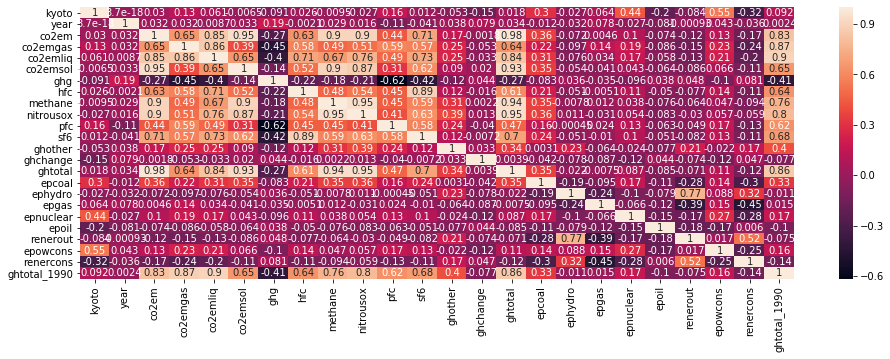

In [0]:
plt.figure(figsize = (16,5))
corrMatrix = all_countries.corr()
sns.heatmap(corrMatrix, annot=True)

## 3.- <font color = "MediumBlue"> Modelization </font>


In [0]:
model1 = ols('ghtotal ~ co2em + epnuclear + epgas + renercons', data = df_train).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                ghtotal   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     1228.
Date:                Thu, 23 Jan 2020   Prob (F-statistic):          1.08e-211
Time:                        22:41:58   Log-Likelihood:                -5054.2
No. Observations:                 374   AIC:                         1.012e+04
Df Residuals:                     369   BIC:                         1.014e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.497e+04   2.22e+04     -0.674      0.5

In [0]:
#alternative restricted model

model_restricted = ols('ghtotal ~ co2emgas + epnuclear + epgas', data = df_train).fit()
print(model_restricted.summary())

                            OLS Regression Results                            
Dep. Variable:                ghtotal   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     255.2
Date:                Thu, 23 Jan 2020   Prob (F-statistic):           1.03e-89
Time:                        22:41:58   Log-Likelihood:                -5342.1
No. Observations:                 374   AIC:                         1.069e+04
Df Residuals:                     370   BIC:                         1.071e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.42e+05   2.57e+04      5.517      0.0

In [0]:
import statsmodels.stats.anova as anova
anova.anova_lm(model_restricted, model1)

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,370.0,5.584637e+13,0.0,NaN,NaN,NaN
1,369.0,1.197798e+13,1.0,4.386839e+13,1351.433463,2.048381e-125


In [0]:
model_transformed = ols('np.log(ghtotal + 4) ~ np.log(co2emgas + 2) + np.log(epnuclear +2) + np.log(epgas +2)', data = df_train).fit()
print(model_transformed.summary())


                             OLS Regression Results                            
Dep. Variable:     np.log(ghtotal + 4)   R-squared:                       0.375
Model:                             OLS   Adj. R-squared:                  0.370
Method:                  Least Squares   F-statistic:                     74.11
Date:                 Thu, 23 Jan 2020   Prob (F-statistic):           1.48e-37
Time:                         22:41:58   Log-Likelihood:                -724.98
No. Observations:                  374   AIC:                             1458.
Df Residuals:                      370   BIC:                             1474.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept           

### 3.1  <font color = "Blue"> Model Selection </font>


I've built several models before I came to the result, which has some meaningful results of metrics. First, chosen by me variables were based on the correlations, that we can see on the heatmap. 
I was trying to understand, how the total greenhouse gas emissions can be explained by factors, which I saw had the biggest correlation. In this case, I every model had problems with multicolinearity. So, I decided to base on the logic and explanatory analysis. I wanted to see, how electricity production (from nuclear and gas sources) may influence total greenhouse gas emissions. 


### 3.3 <font color = "Blue"> Model Assumptions </font>

**Does the model satisfy the assumptions of the MLRM? (normality of the residuals, linearity, homoskedasticity)?**

In [0]:
import statsmodels.stats.outliers_influence as sso
sso.reset_ramsey(model_transformed, degree = 2)


<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[37.46940112]]), p=2.3750979218550092e-09, df_denom=369, df_num=1>

In [0]:
residuals = model_transformed.resid
residuals.mean()

1.9497178678443927e-15

In [0]:
NormalityTests(residuals, 0.05)

From the Shapiro Wilk test:

Statistic:  0.9492529034614563 
p-value:  4.909550543885643e-10
Reject Normality: Evidence found against normality


From the D'Agostino test:

Statistic:  55.68816474914806 
p-value:  8.08106632182506e-13
Reject Normality: Evidence found against normality




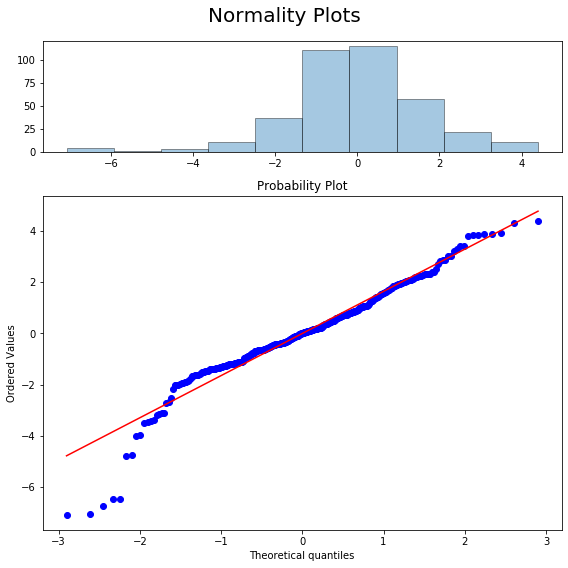

In [0]:
HisQQplots(residuals)

## 4. <font color = "MediumBlue">Categorical Variable</font>


### 4.1.-  <font color = "Blue"> Comparison of Populations </font> 

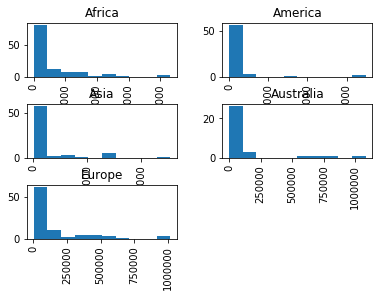

In [0]:
df_train.hist(column = 'ghtotal', by = 'continent')
plt.show()

In [0]:
model_anova = ols('ghtotal ~ C(continent)', data = df_train).fit()
print(model_anova.summary())

                            OLS Regression Results                            
Dep. Variable:                ghtotal   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     4.946
Date:                Thu, 23 Jan 2020   Prob (F-statistic):           0.000679
Time:                        22:41:59   Log-Likelihood:                -5542.0
No. Observations:                 374   AIC:                         1.109e+04
Df Residuals:                     369   BIC:                         1.111e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [0]:
aov_table = sm.stats.anova_lm(model_anova, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(continent),8.721249e+12,4.0,4.946085,0.000679
Residual,1.626610e+14,369.0,NaN,NaN


### 4.2.- <font color = "Blue"> Linear Model </font>  

#### 4.2.1. Creating the Variable

**If you have not done it yet, create a dummy variable in the dataset, named `kyoto`, such that it denotes those countries which signed the protocol and those who did not**

#### 4.3.2. Estimate the Model

**Add this dummy variable to the model in question 3**

#### 4.3.3. Chow Test

**Perform a Chow test with this variable to see if signing the protocol actually made a difference in the greenhouse emissions**


In [0]:
kyoto_model = ols('np.log(ghtotal + 4) ~ np.log(co2emgas + 2) + np.log(epnuclear +2) + np.log(epgas +2)', data = df_train[df_train.kyoto == 1]).fit()
not_kyoto_model = ols('np.log(ghtotal + 4) ~ np.log(co2emgas + 2) + np.log(epnuclear +2) + np.log(epgas +2)', data = df_train[df_train.kyoto == 0]).fit()

In [0]:
RSSp = np.sum(model_restricted.resid**2)
RSS1 = np.sum(kyoto_model.resid**2)
RSS2 = np.sum(not_kyoto_model.resid**2)

In [0]:
K = 4
n = all_countries.shape[0]

In [0]:
int_F_value = ( RSSp - ( RSS1 + RSS2 ))/(RSS1 + RSS2)*(n - 2*(K+1))/(K)
int_p_value = 1 - ss.f.cdf(int_F_value, K, n - 2*(K+1))

print("F-stats: ", int_F_value, "\np-value: ", int_p_value)

F-stats:  6274116027656.339 
p-value:  1.1102230246251565e-16


In [0]:
slo_F_value = ( RSSp - ( RSS1 + RSS2 ))/(RSS1 + RSS2)*(n - 2*(K+1))/(K+1)
slo_p_value = 1 - ss.f.cdf(slo_F_value, K+1, n - 2*(K+1))

print("F-stats: ", slo_F_value, "\np-value: ", slo_p_value)

F-stats:  5019292822125.071 
p-value:  1.1102230246251565e-16


#### 4.3.4. Final Model
 

In [0]:
kyoto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.log(ghtotal + 4)   R-squared:                       0.842
Model:                             OLS   Adj. R-squared:                  0.836
Method:                  Least Squares   F-statistic:                     141.6
Date:                 Thu, 23 Jan 2020   Prob (F-statistic):           6.57e-32
Time:                         22:42:00   Log-Likelihood:                -74.333
No. Observations:                   84   AIC:                             156.7
Df Residuals:                       80   BIC:                             166.4
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 6.2620      0.322     19.431      0.000       5.621       6.903
np.log(co2emgas + 2)      0.7081      0.037     19.238      0.000       0.635       0.781
np.log(epnuclear + 2)    -0.0774      0.053     -1.457      0.149      -0.183       0.028
np.log(epgas + 2)        -0.4356      0.078     -5.583      0.000      -0.591      -0.280
==============================================================================
Omnibus:                       21.281   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.353
Skew:                           1.037   Prob(JB):                     5.72e-08
Kurtosis:                       5.286   Cond. No.                         52.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 4.3.5. Interpretation

the p-values for both intercepts and slopes in the Chow test are bigger than any common significance level. That means, that we have evidence in favor or rejecting null hypothesis. Hence, there is a difference when we include kyoto variable in our model. 
That's why in this case I would keep last model, where we take into account whether kyoto protocol was signed or not.